In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import zipfile
from imblearn.over_sampling import RandomOverSampler

# Optional: install imbalanced-learn for oversampling
%pip install imblearn
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Function to define paths and labels for skin burn images
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)  # This assumes folder names are 'degree1', 'degree2', 'degree3'
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


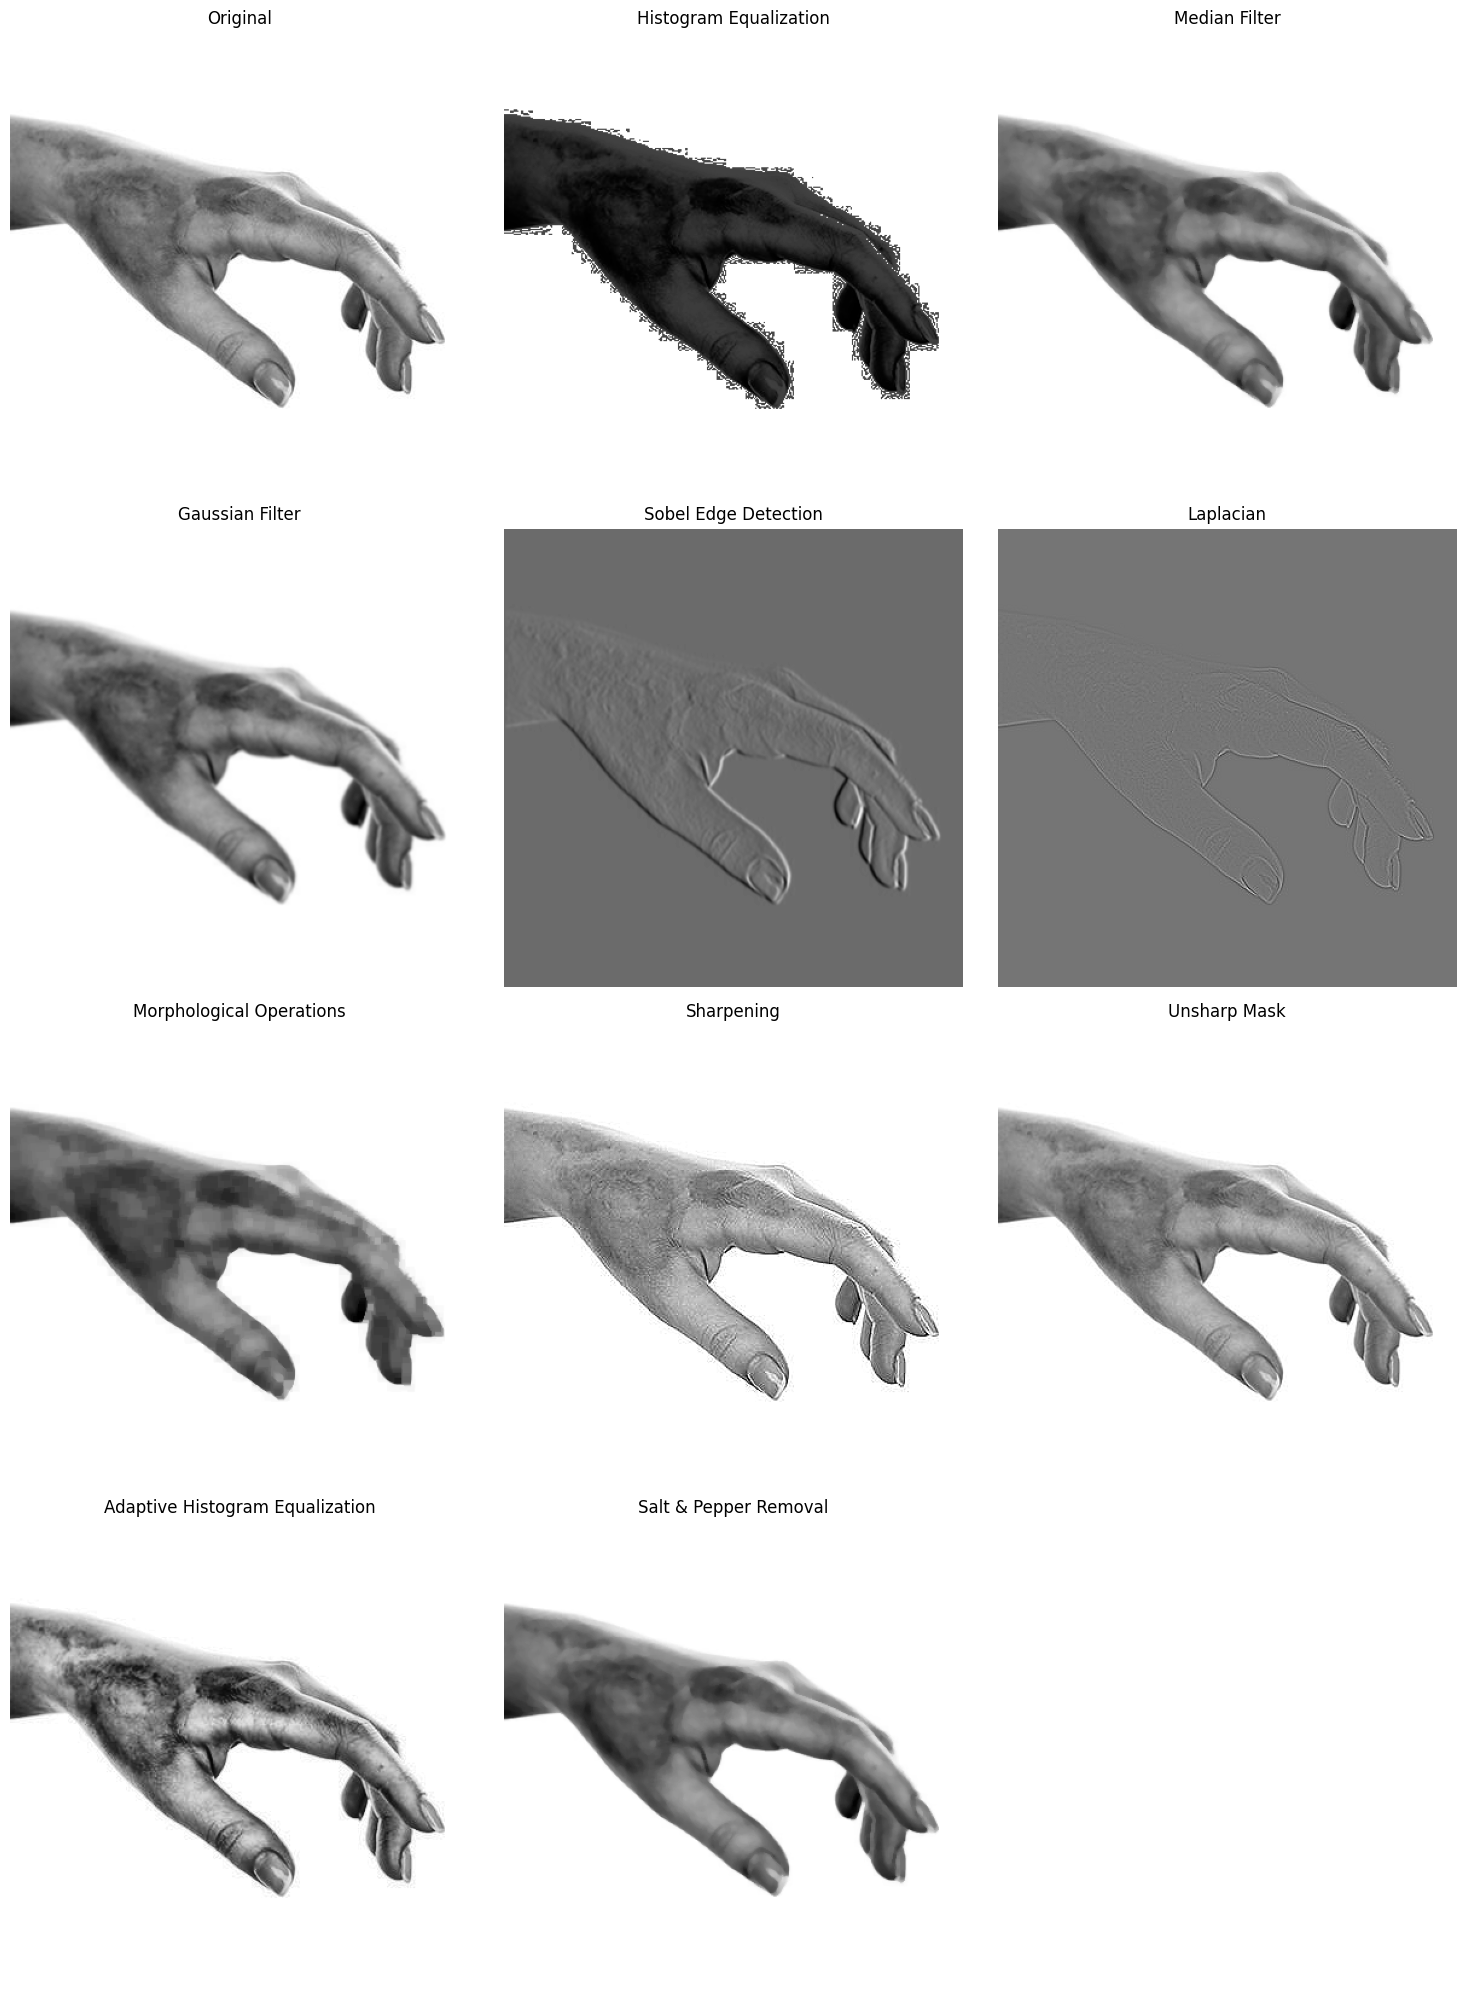

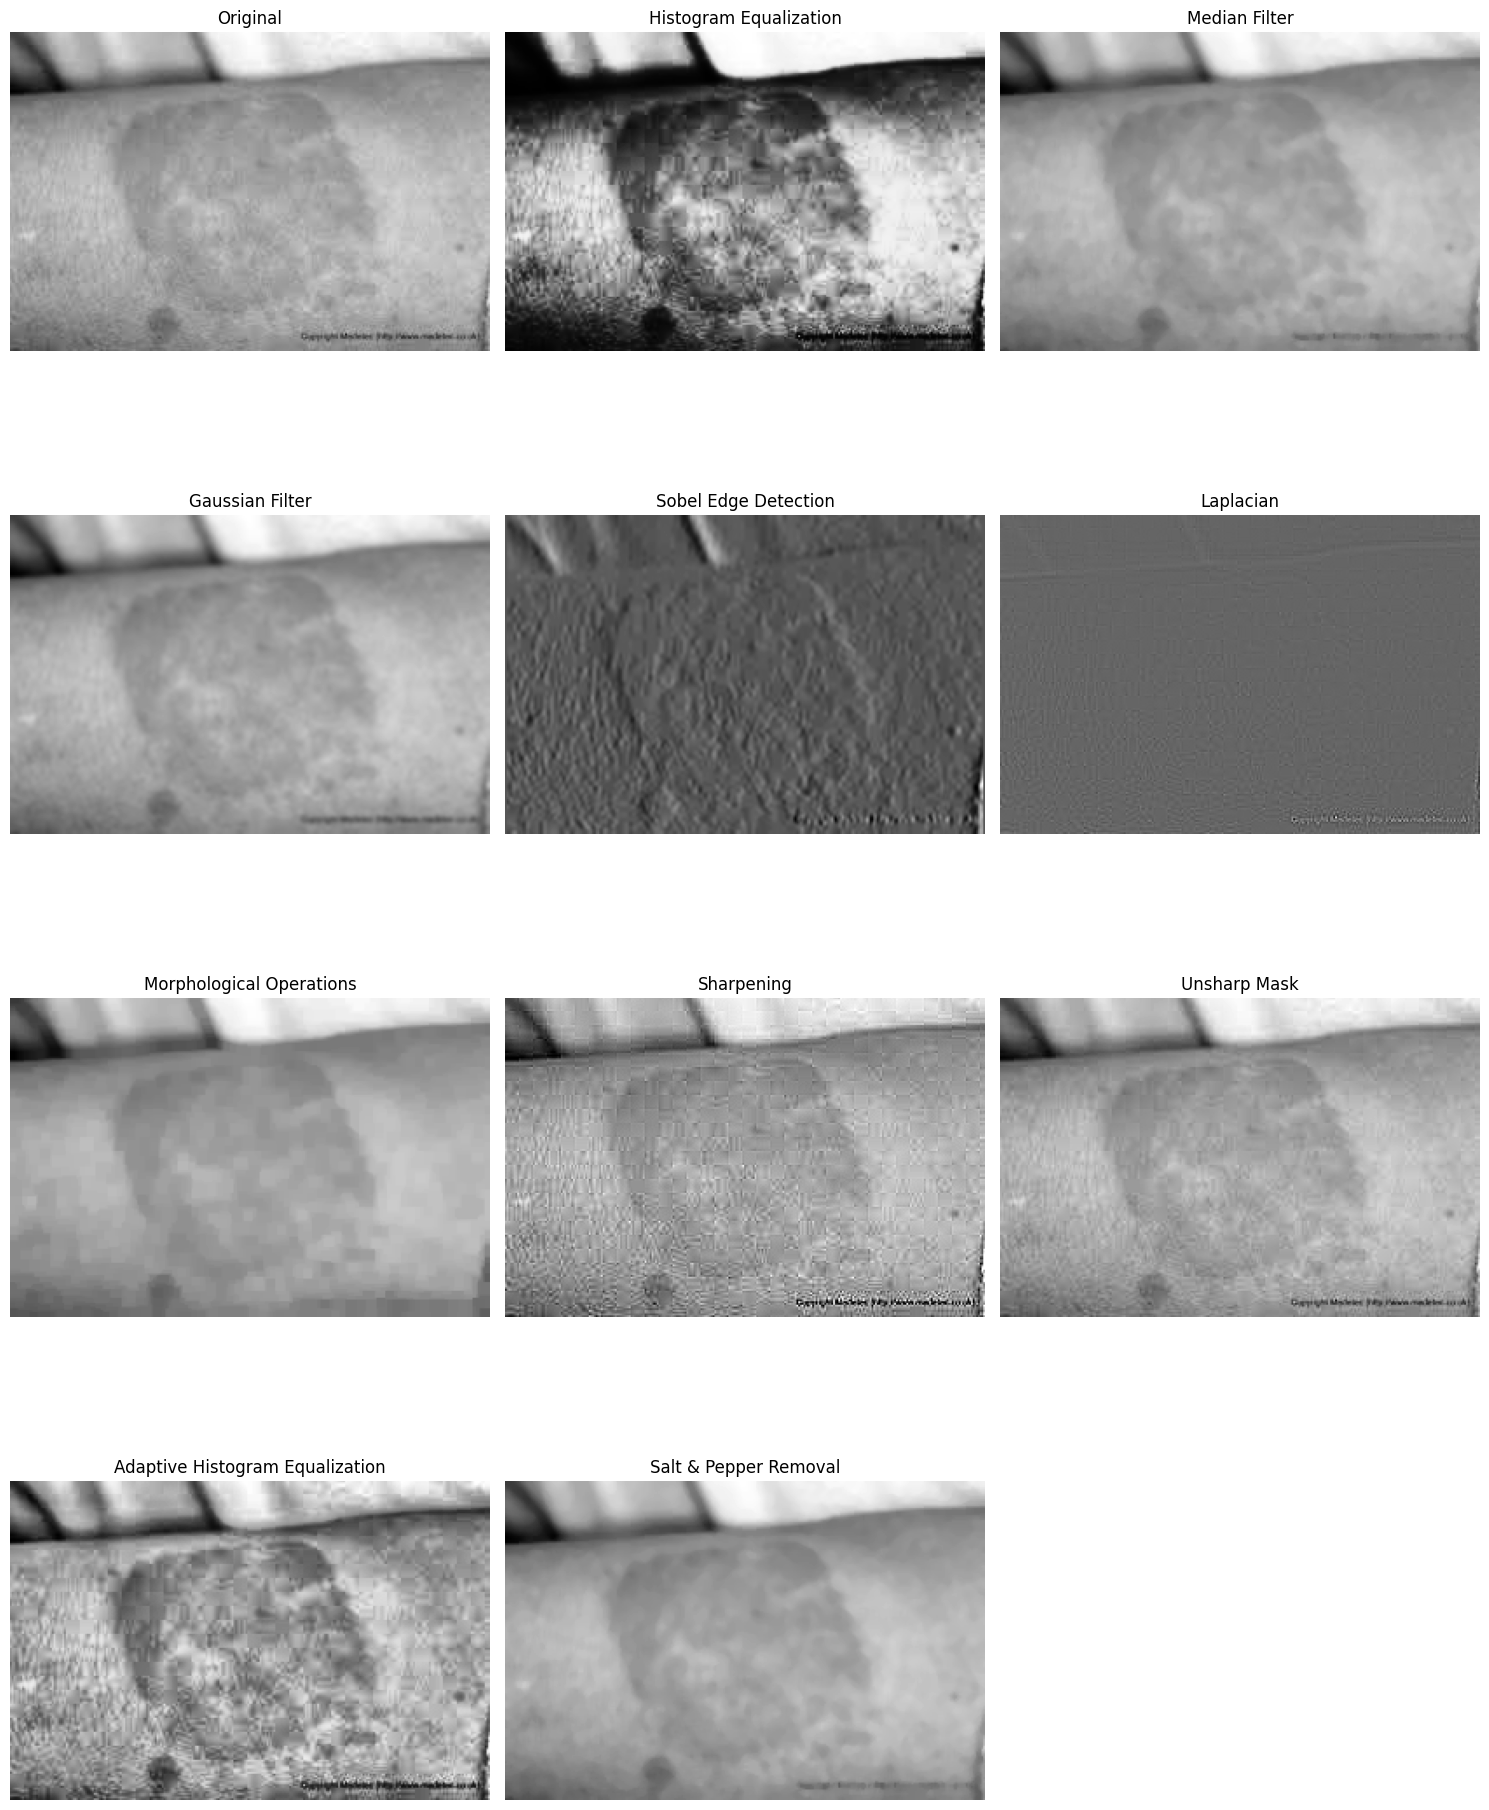

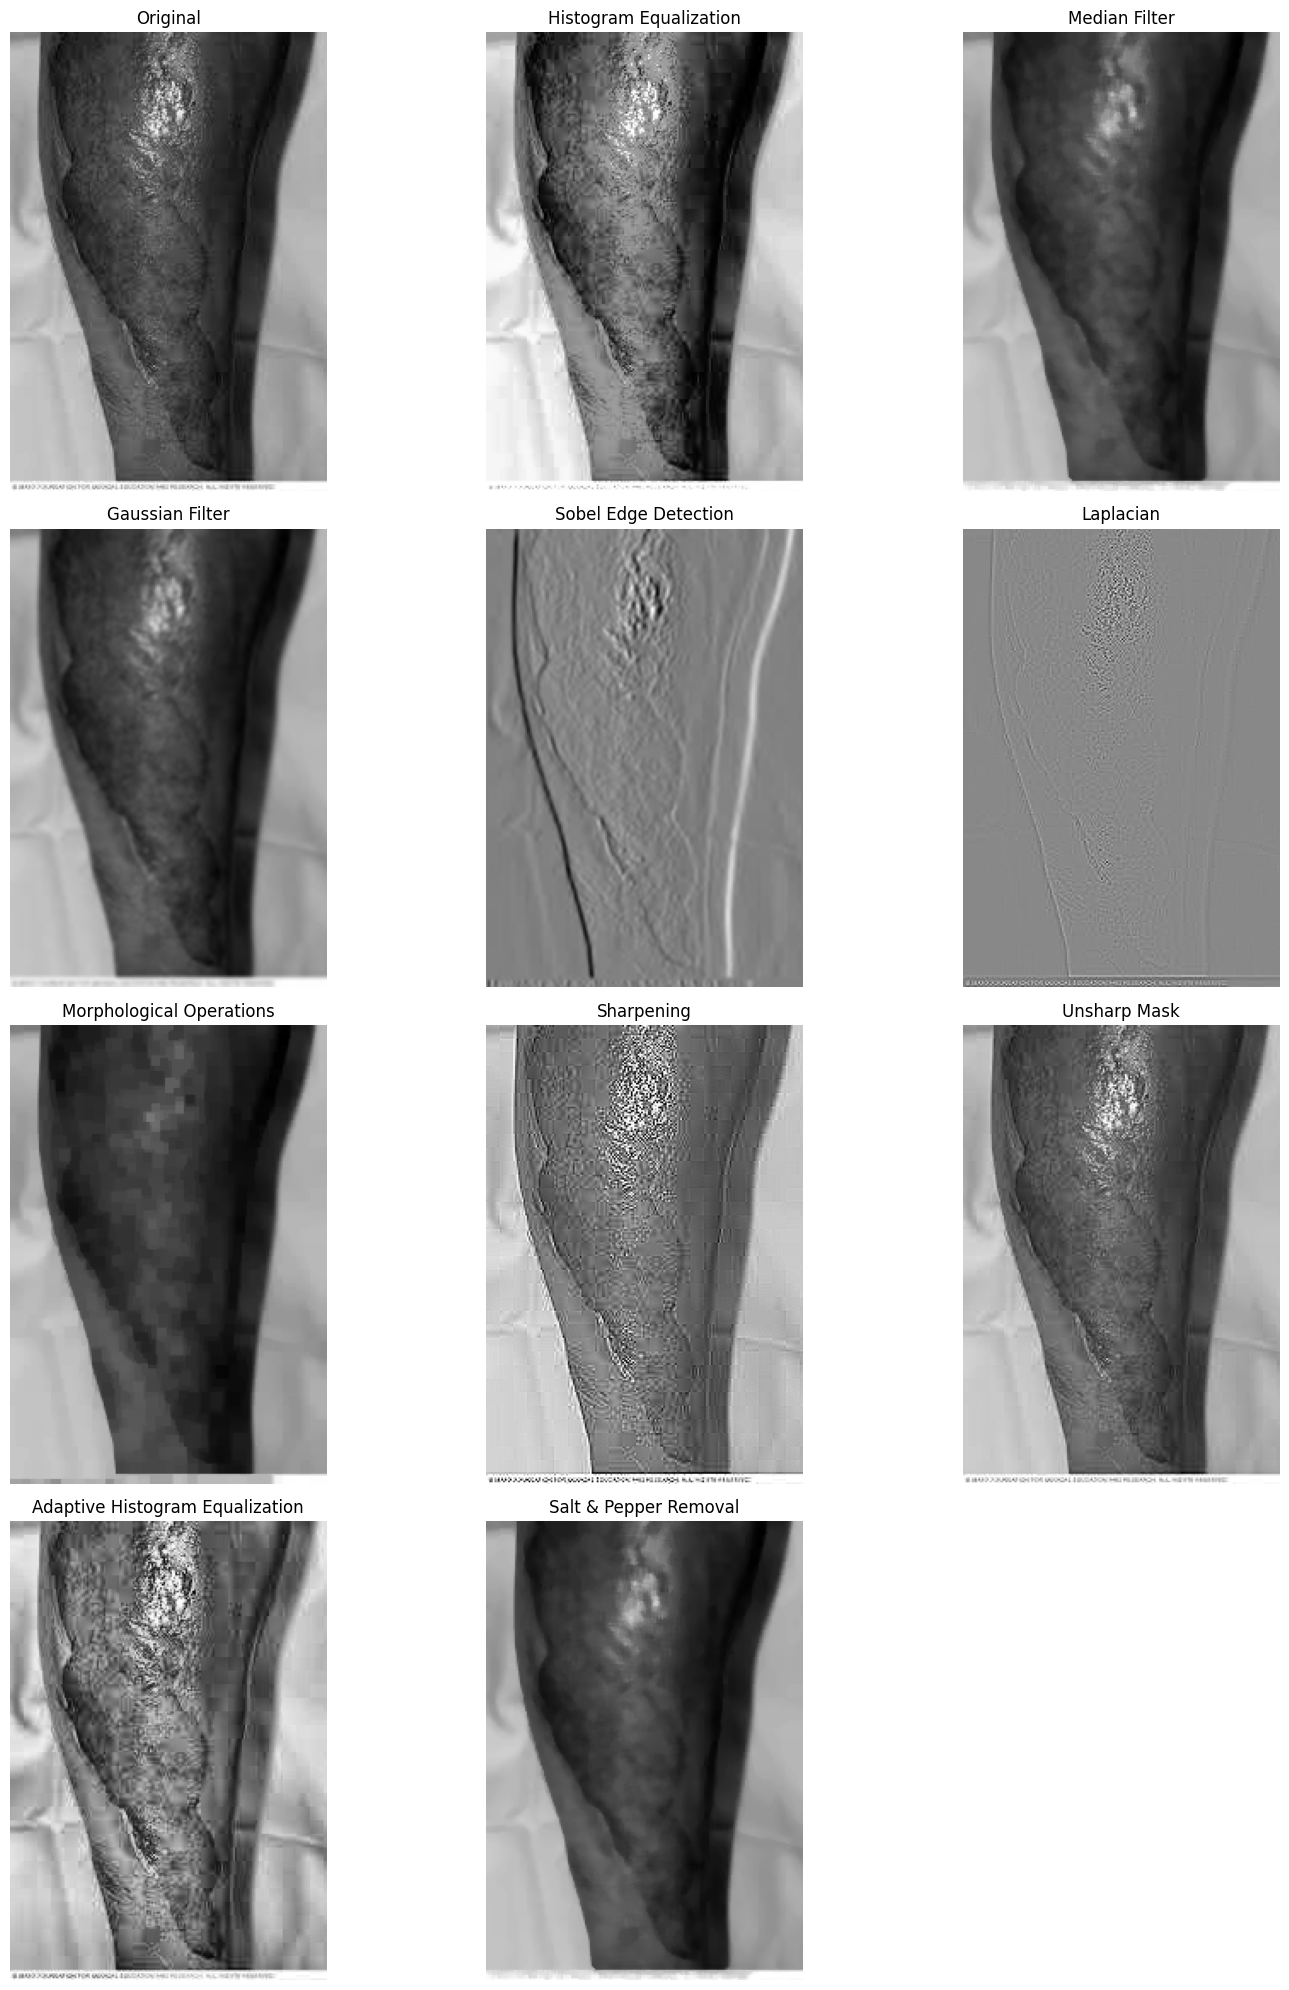

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create DataFrame with image paths and labels
def create_df(image_directory):
    """
    Creates a DataFrame with image paths and labels.
    Parameters:
        image_directory (str): Path to the directory containing images organized by folders.
    Returns:
        pd.DataFrame: A DataFrame with columns 'filepaths' and 'labels'.
    """
    data = []
    for label in os.listdir(image_directory):
        label_path = os.path.join(image_directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image extensions
                    data.append({'filepaths': image_path, 'labels': label})
    return pd.DataFrame(data)

# Preprocessing functions
def apply_gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_histogram_equalization(image):
    return cv2.equalizeHist(image)

def apply_median_filter(image):
    return cv2.medianBlur(image, 5)

def apply_sobel_edge_detection(image):
    return cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

def apply_morphological_operations(image):
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

def apply_laplacian_edge_detection(image):
    return cv2.Laplacian(image, cv2.CV_64F)

def apply_sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def apply_unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def apply_salt_and_pepper_removal(image):
    return cv2.medianBlur(image, 5)

# Function to display images
def display_images(images, titles):
    rows = (len(images) // 3) + (1 if len(images) % 3 != 0 else 0)
    plt.figure(figsize=(15, rows * 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Modify the image path for your dataset
image_directory = '/content/drive/MyDrive/data/Burns'

# Create a DataFrame with image paths and labels
df = create_df(image_directory)

# Select sample images
degree1_image = df[df['labels'] == 'degree1'].iloc[1]['filepaths']
degree2_image = df[df['labels'] == 'degree2'].iloc[6]['filepaths']
degree3_image = df[df['labels'] == 'degree3'].iloc[3]['filepaths']

# Load images
image_degree1 = cv2.imread(degree1_image, cv2.IMREAD_GRAYSCALE)
image_degree2 = cv2.imread(degree2_image, cv2.IMREAD_GRAYSCALE)
image_degree3 = cv2.imread(degree3_image, cv2.IMREAD_GRAYSCALE)

# Preprocess images for each burn level
def preprocess_image(image):
    return [
        image,  # Original first
        apply_histogram_equalization(image),
        apply_median_filter(image),
        apply_gaussian_filter(image),
        apply_sobel_edge_detection(image),
        apply_laplacian_edge_detection(image),
        apply_morphological_operations(image),
        apply_sharpening(image),
        apply_unsharp_mask(image),
        apply_adaptive_histogram_equalization(image),
        apply_salt_and_pepper_removal(image),
    ]

titles = [
    'Original', 'Histogram Equalization', 'Median Filter', 'Gaussian Filter',
    'Sobel Edge Detection', 'Laplacian', 'Morphological Operations',
    'Sharpening', 'Unsharp Mask', 'Adaptive Histogram Equalization',
    'Salt & Pepper Removal'
]

# Display results
display_images(preprocess_image(image_degree1), titles)
display_images(preprocess_image(image_degree2), titles)
display_images(preprocess_image(image_degree3), titles)


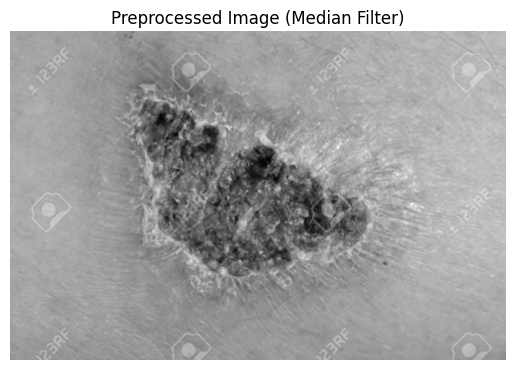

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Preprocess image function (Only Median Filter)
def preprocess_image(image):
    # Apply Median Filtering
    image_median = cv2.medianBlur(image, 5)

    return image_median

# Load a random image from your dataset (example: a burn image)
image_path = '/content/drive/MyDrive/data/Burns/degree2/img1205.jpg'  # Update with your actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if image is None:
    print(f"Error: Image at {image_path} could not be loaded.")
else:
    # Apply preprocessing
    preprocessed_image = preprocess_image(image)

    # Display the preprocessed image
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title('Preprocessed Image (Median Filter)')
    plt.axis('off')
    plt.show()


Data Inspection Utilities
here we try to make the data more balance

In [ ]:
def count_images_in_folders(data_dir):
    """Count and print the number of images in each subfolder."""
    class_names = sorted(os.listdir(data_dir))
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            print(f"Class '{class_name}': {image_count} images")

def display_sample_images(data_dir, samples_per_class=3, target_size=(224, 224)):
    """Displays a few sample images from each class."""
    class_names = sorted(os.listdir(data_dir))
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]

        fig, axes = plt.subplots(1, len(image_files), figsize=(5*len(image_files),5))
        fig.suptitle(f"Class: {class_name}", fontsize=16)

        for i, img_name in enumerate(image_files):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, target_size)
                ax = axes if len(image_files) == 1 else axes[i]
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                ax.axis('off')
        plt.show()

def inspect_image_shapes(data_dir, max_images=50):
    """Check shapes of up to max_images in each class folder."""
    shapes = []
    class_names = sorted(os.listdir(data_dir))
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            for img_name in image_files[:max_images]:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    shapes.append(img.shape)
    print(f"Checked {len(shapes)} images.")
    unique_shapes = list(set(shapes))
    print("Unique shapes encountered:", unique_shapes)

def compute_color_stats(data_dir, max_images=50):
    """Computes average mean and std for each color channel across a subset of images."""
    means, stds = [], []
    count = 0
    class_names = sorted(os.listdir(data_dir))

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:max_images]
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = img.astype(np.float32) / 255.0
                    means.append(np.mean(img, axis=(0,1)))  # (B, G, R)
                    stds.append(np.std(img, axis=(0,1)))
                    count += 1
    if count == 0:
        print("No valid images found.")
        return

    overall_mean = np.mean(means, axis=0)
    overall_std = np.mean(stds, axis=0)
    print(f"Analyzed {count} images.")
    print("Overall Mean (B, G, R):", overall_mean)
    print("Overall Std Dev (B, G, R):", overall_std)

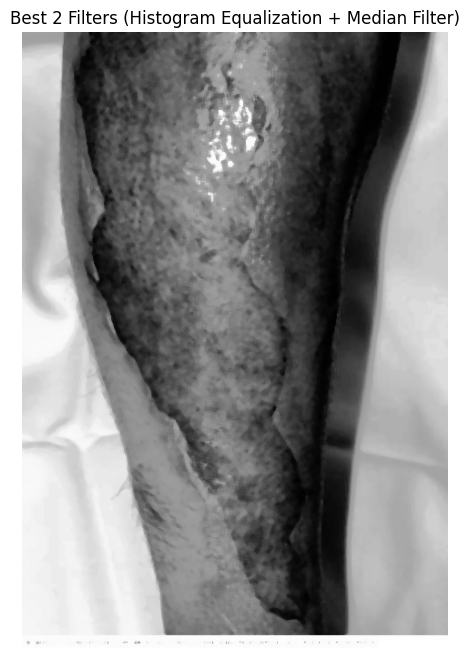

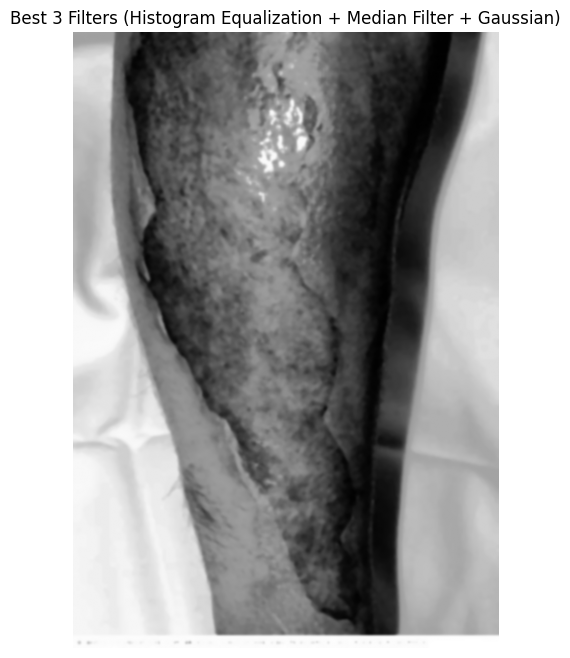

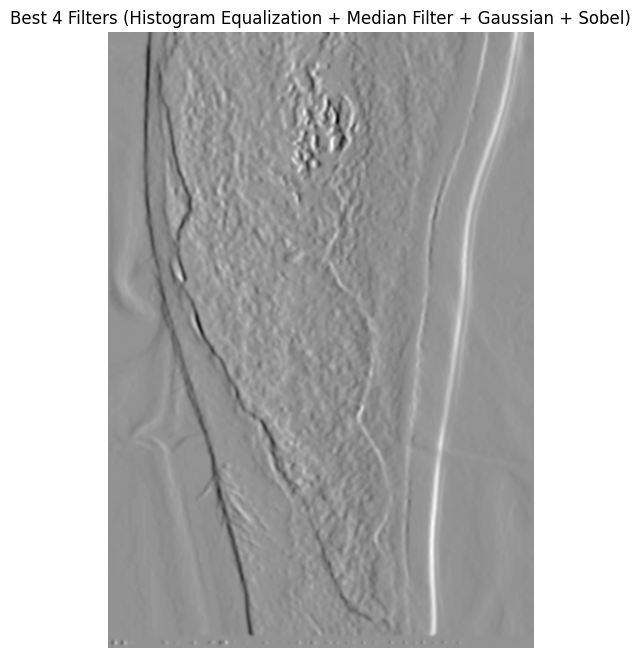

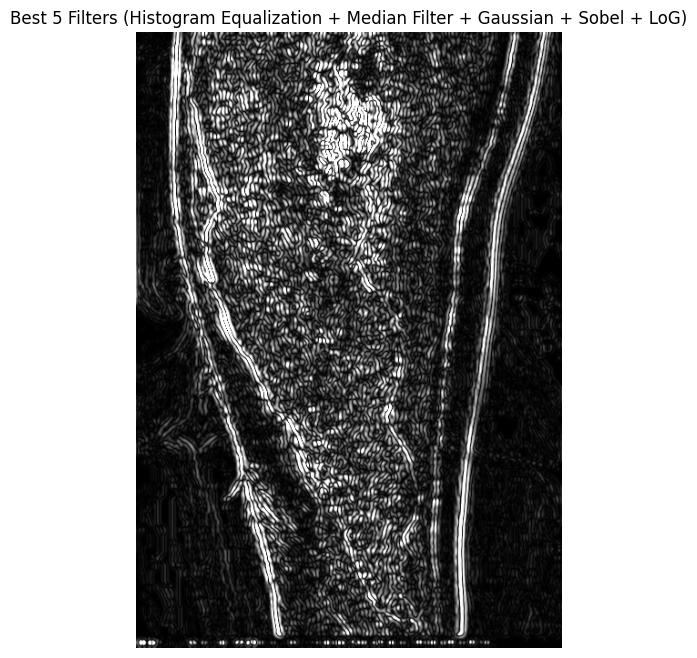

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Preprocess image function with different filter combinations
def preprocess_image(image, filters):
    processed_image = image.copy()
    for filter_func in filters:
        processed_image = filter_func(processed_image)
    return processed_image

# Filter functions
def apply_histogram_equalization(image):
    return cv2.equalizeHist(image)

def apply_median_filter(image):
    return cv2.medianBlur(image, 5)

def apply_gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_sobel_edge_detection(image):
    return cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

def apply_laplacian_of_gaussian(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    laplacian_image = cv2.Laplacian(blurred_image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian_image)

def apply_closing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# Load a random image from your dataset (example: a burn image)
image_path = '/content/drive/MyDrive/data/Burns/degree2/img1217.jpg'  # Update with your actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if image is None:
    print(f"Error: Image at {image_path} could not be loaded.")
else:
    # Combination of filters
    filter_combinations = {
        'Best 2 Filters (Histogram Equalization + Median Filter)': [apply_histogram_equalization, apply_median_filter],
        'Best 3 Filters (Histogram Equalization + Median Filter + Gaussian)': [apply_histogram_equalization, apply_median_filter, apply_gaussian_filter],
        'Best 4 Filters (Histogram Equalization + Median Filter + Gaussian + Sobel)': [apply_histogram_equalization, apply_median_filter, apply_gaussian_filter, apply_sobel_edge_detection],
        'Best 5 Filters (Histogram Equalization + Median Filter + Gaussian + Sobel + LoG)': [apply_histogram_equalization, apply_median_filter, apply_gaussian_filter, apply_sobel_edge_detection, apply_laplacian_of_gaussian],
        }

    # Apply each combination and display the result
    for title, filters in filter_combinations.items():
        processed_image = preprocess_image(image, filters)

        # Display the processed image for each filter combination
        plt.figure(figsize=(8, 8))
        plt.imshow(processed_image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

In [ ]:
def apply_gaussian(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

def apply_sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    return cv2.convertScaleAbs(sobel)

def apply_unsharp(image):
    gaussian = cv2.GaussianBlur(image, (9, 9), 10.0)
    return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)

def combined_filters(image):
    c = apply_clahe(image)
    s = apply_sobel(image)
    comb = cv2.addWeighted(c, 0.5, s, 0.5, 0)
    comb = cv2.merge([comb, comb, comb])
    return apply_unsharp(comb)

Filtering Functions

Preprocessing with optional **filter**

In [ ]:
def preprocess_images_with_labels(data_dir, target_size=(224, 224), use_filter=None):
    """
    Loads images from each class folder, resizes, applies optional filter.
    Returns X, y, class_names.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if not img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                    # Apply optional filter
                    if use_filter == "combined":
                        img = combined_filters(img)
                    elif use_filter == "clahe":
                        gray = apply_clahe(img)
                        img = cv2.merge([gray, gray, gray])
                    elif use_filter == "gaussian":
                        img = apply_gaussian(img)
                    elif use_filter == "sobel":
                        gray = apply_sobel(img)
                        img = cv2.merge([gray, gray, gray])
                    elif use_filter == "unsharp":
                        img = apply_unsharp(img)
                    # else "original"

                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels), class_names

Model: Partially Fine-Tuned **ResNet50**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report


In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Define the original dataset path
original_dataset_path = '/content/drive/MyDrive/data/Burns'

# Define split directories
train_split_path = os.path.join(base_split_path, 'train')
val_split_path = os.path.join(base_split_path, 'val')
test_split_path = os.path.join(base_split_path, 'test')

os.makedirs(train_split_path, exist_ok=True)
os.makedirs(val_split_path, exist_ok=True)
os.makedirs(test_split_path, exist_ok=True)

# Perform the split
def split_data_adjusted(class_name, class_path):
    images = os.listdir(class_path)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for subset, subset_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        subset_dir = os.path.join(base_split_path, subset, class_name)
        os.makedirs(subset_dir, exist_ok=True)
        for img in subset_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(subset_dir, img))

for class_dir in os.listdir(original_dataset_path):
    class_path = os.path.join(original_dataset_path, class_dir)
    split_data_adjusted(class_dir, class_path)


In [ ]:
import os

# Define paths based on your dataset split
base_split_path = '/content/drive/MyDrive/data'  # Update if necessary
train_split_path = os.path.join(base_split_path, 'train')
val_split_path = os.path.join(base_split_path, 'val')
test_split_path = os.path.join(base_split_path, 'test')

# Verify directories exist
print("Train Path:", train_split_path)
print("Validation Path:", val_split_path)
print("Test Path:", test_split_path)

# Load data from split directories
train_generator = train_datagen.flow_from_directory(
    train_split_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_split_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_split_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Train Path: /content/drive/MyDrive/data/train
Validation Path: /content/drive/MyDrive/data/val
Test Path: /content/drive/MyDrive/data/test
Found 642 images belonging to 3 classes.
Found 138 images belonging to 3 classes.
Found 604 images belonging to 3 classes.


In [ ]:

# 1. Build a custom CNN model
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# 2. Model Parameters
input_shape = (224, 224, 3)  # Input shape of the images
num_classes = 10  # Number of output classes


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# 1. Define the model structure with filters similar to your shared notebook
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# 2. Model Parameters
input_shape = (224, 224, 3)  # Image dimensions
num_classes = 3  # Based on your dataset split


In [ ]:

# 3. Build the model
model = create_custom_cnn(input_shape=input_shape, num_classes=num_classes)

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data from split directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(extracted_folder_path, 'split/train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(extracted_folder_path, 'split/val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(extracted_folder_path, 'split/test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 6. Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Adjust based on dataset stability
    callbacks=[lr_scheduler, early_stopping]
)

# 8. Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions and Classification Report
preds = model.predict(test_generator)
y_pred = preds.argmax(axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Save the model
model.save('custom_cnn_filters.h5')

NameError: name 'extracted_folder_path' is not defined